In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: F

In [2]:
len("TTTCTGAGCATCCCGGGGATCCC")

23

In [3]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [4]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [5]:
DATAPATH = "/home/bakirillov/HDD/data/genomes/all_guides_chr22.tsv"
ANNOTATION = "/home/bakirillov/HDD/data/genomes/annotation.csv"

In [6]:
annotation = pd.read_csv(ANNOTATION, header=1)[["Start", "Stop", "Gene symbol"]]
annotation = list(
    zip(
        annotation["Start"].values, annotation["Stop"].values, 
        annotation["Gene symbol"].values
    )
)
annotation = sorted(annotation, key=lambda x: x[0])

In [7]:
transformer = get_Cas9_transformer(True)

In [8]:
chr22 = SeqIO.parse("/home/bakirillov/HDD/data/genomes/chr22.fa", "fasta")
chr22 = [a for a in chr22][0]

In [9]:
TEMPLATE = "/home/bakirillov/HDD/data/chr22_genes/GENE\nNNNNNNNNNNNNNNNNNNNNNGG\nNNNNNNNNNNNNNNNNNNNNNGG 0\n"
COMMAND = "/home/bakirillov/HDD/apps/cas-offinder CONFIG G OUTPUT"

In [10]:
script = open("run_casoffinder.sh", "w")
script.write("#!/bin/sh\n\n")
for start, stop, gene in tqdm(annotation):
    with open("/home/bakirillov/HDD/data/chr22_genes/"+gene+".fa", "w") as oh:
        oh.write(">"+gene+"\n")
        oh.write(str(chr22.seq[start:stop]))
    with open("/home/bakirillov/HDD/data/chr22_casoffinder_configs/"+gene+".txt", "w") as oh:
        oh.write(TEMPLATE.replace("GENE", gene+".fa"))
    script.write(
        COMMAND.replace(
            "CONFIG", "/home/bakirillov/HDD/data/chr22_casoffinder_configs/"+gene+".txt"
        ).replace(
            "OUTPUT", "/home/bakirillov/HDD/data/chr22_grnas/"+gene+".tsv"
        )+"\n"
    )
script.close()

100%|██████████| 1186/1186 [00:01<00:00, 984.13it/s]


In [11]:
cnn_mse_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_mse = DKL(cnn_mse_encoder, [1,5*32]).cuda()
cnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_mse59.ptch"))
cnn_mse = cnn_mse.eval()

In [12]:
rnn_mse_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_mse = DKL(rnn_mse_encoder, [1,5*32]).cuda()
rnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_mse59.ptch"))
rnn_mse = rnn_mse.eval()

In [13]:
cnn_elbo_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_elbo = DKL(cnn_elbo_encoder, [1,5*32]).cuda()
cnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_elbo59.ptch"))
cnn_elbo = cnn_elbo.eval()

In [14]:
rnn_elbo_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_elbo = DKL(rnn_elbo_encoder, [1,5*32]).cuda()
rnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_elbo59.ptch"))
rnn_elbo = rnn_elbo.eval()

In [15]:
data = np.array(
    [a for a in os.walk("/home/bakirillov/HDD/data/chr22_grnas/")][0][2]
)

In [16]:
sizes = np.array(
    [op.getsize(op.join("/home/bakirillov/HDD/data/chr22_grnas", a)) for a in data]
)

In [17]:
genes = {a[2]: [] for a in annotation}
GS = {a[2]: [] for a in annotation}

In [18]:
data

array(['SERPIND1.tsv', 'HSFY1P1.tsv', 'SLC25A15P5.tsv', ..., 'H1-0.tsv',
       'CRYBA4.tsv', 'RPL3.tsv'], dtype='<U21')

In [19]:
for i,a in enumerate(data):
    #with open(op.join("/home/bakirillov/HDD/data/casoffinder_data/", a), "r"):
    current_df = pd.read_csv(
        op.join(
            "/home/bakirillov/HDD/data/chr22_grnas/"+a
        ), sep="\t", header=None
    ).dropna()
    current_df = current_df[current_df[3].apply(lambda x: len(x) == 23)]
    current_df[6] = [a]*current_df.shape[0]
    print(i, current_df.shape)
    tds = DeepHFDataset(
        current_df, np.arange(current_df.shape[0]), transformer, sequence_column=3, 
        label_column=5
    )
    tld = DataLoader(tds, shuffle=False, batch_size=256)
    tb_cnn_mse_oa = []
    tb_cnn_mse_va = []
    tb_rnn_mse_oa = []
    tb_rnn_mse_va = []
    tb_cnn_elbo_oa = []
    tb_cnn_elbo_va = []
    tb_rnn_elbo_oa = []
    tb_rnn_elbo_va = []
    tb_cnn_mse_ra = []
    tb_rnn_mse_ra = []
    tb_cnn_elbo_ra = []
    tb_rnn_elbo_ra = []
    for transformed_batch, _ in tqdm(tld):
        tb_cnn_mse_o = cnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
        tb_cnn_mse_ra.extend(tb_cnn_mse_o)
        tb_rnn_mse_o = rnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
        tb_rnn_mse_ra.extend(tb_rnn_mse_o)
        tb_cnn_elbo_o = cnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
        tb_cnn_elbo_ra.extend(tb_cnn_elbo_o)
        tb_rnn_elbo_o = rnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
        tb_rnn_elbo_ra.extend(tb_rnn_elbo_o)
        tb_cnn_mse = cnn_mse(transformed_batch)
        tb_cnn_mse_o = cnn_mse.likelihood(
            tb_cnn_mse[0]
        ).mean.mean(0).cpu().data.numpy()
        tb_cnn_mse_v = cnn_mse.likelihood(
            tb_cnn_mse[0]
        ).variance.mean(0).cpu().data.numpy()
        tb_cnn_mse_oa.extend(tb_cnn_mse_o)
        tb_cnn_mse_va.extend(tb_cnn_mse_v)
        tb_rnn_mse = rnn_mse(transformed_batch)
        tb_rnn_mse_o = rnn_mse.likelihood(
            tb_rnn_mse[0]
        ).mean.mean(0).cpu().data.numpy()
        tb_rnn_mse_v = rnn_mse.likelihood(
            tb_rnn_mse[0]
        ).variance.mean(0).cpu().data.numpy()
        tb_rnn_mse_oa.extend(tb_rnn_mse_o)
        tb_rnn_mse_va.extend(tb_rnn_mse_v)
        tb_cnn_elbo = cnn_elbo(transformed_batch)
        tb_cnn_elbo_o = cnn_elbo.likelihood(
            tb_cnn_elbo[0]
        ).mean.mean(0).cpu().data.numpy()
        tb_cnn_elbo_v = cnn_elbo.likelihood(
            tb_cnn_elbo[0]
        ).variance.mean(0).cpu().data.numpy()
        tb_cnn_elbo_oa.extend(tb_cnn_elbo_o)
        tb_cnn_elbo_va.extend(tb_cnn_elbo_v)
        tb_rnn_elbo = rnn_elbo(transformed_batch)
        tb_rnn_elbo_o = rnn_elbo.likelihood(
            tb_rnn_elbo[0]
        ).mean.mean(0).cpu().data.numpy()
        tb_rnn_elbo_v = rnn_elbo.likelihood(
            tb_rnn_elbo[0]
        ).variance.mean(0).cpu().data.numpy()
        tb_rnn_elbo_oa.extend(tb_rnn_elbo_o)
        tb_rnn_elbo_va.extend(tb_rnn_elbo_v)
    current_df[7] = tb_cnn_mse_oa
    current_df[8] = tb_cnn_mse_va
    current_df[9] = tb_rnn_mse_oa
    current_df[10] = tb_rnn_mse_va
    current_df[11] = tb_cnn_elbo_oa
    current_df[12] = tb_cnn_elbo_va
    current_df[13] = tb_rnn_elbo_oa
    current_df[14] = tb_rnn_elbo_va
    current_df[15] = (current_df[7] + current_df[9])/2
    current_df[16] = current_df[8] + current_df[10]
    current_df[17] = (current_df[11] + current_df[13])/2
    current_df[18] = current_df[12] + current_df[14]
    current_df = current_df.sort_values(by=7, ascending=False)
    current_df.to_csv(
        op.join(
            "/home/bakirillov/HDD/data/chr22_ordered/"+a
        ), sep="\t", header=None
    )
    try:
        tb_cnn_mse_ra = np.stack(tb_cnn_mse_ra).reshape(-1, 5*32)
        tb_rnn_mse_ra = np.stack(tb_rnn_mse_ra).reshape(-1, 5*32)
        tb_cnn_elbo_ra = np.stack(tb_cnn_elbo_ra).reshape(-1, 5*32)
        tb_rnn_elbo_ra = np.stack(tb_rnn_elbo_ra).reshape(-1, 5*32)
    except Exception as E:
        print(E)
    else:
        with open(
            op.join(
                "/home/bakirillov/HDD/data/chr22_ordered_GS/"+a+".pkl"
            ), "wb"
        ) as oh:
            pkl.dump(
                (
                    tb_cnn_mse_ra, tb_rnn_mse_ra, tb_cnn_elbo_ra, tb_rnn_elbo_ra, 
                    current_df[3].values, tb_cnn_mse_oa, tb_cnn_mse_va,
                    tb_rnn_mse_oa, tb_rnn_mse_va, tb_cnn_elbo_oa,
                    tb_cnn_elbo_va, tb_rnn_elbo_oa, tb_rnn_elbo_va
                ), oh
            )

  0%|          | 0/7 [00:00<?, ?it/s]

0 (1743, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1 (116, 7)
2 (123, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.53it/s]

3 (3778, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.47it/s]

4 (288, 7)


  4%|▍         | 1/25 [00:00<00:04,  5.76it/s]

5 (6256, 7)


  0%|          | 0/22 [00:00<?, ?it/s]

6 (4, 7)
7 (5434, 7)


  2%|▏         | 1/45 [00:00<00:07,  6.06it/s]

8 (11316, 7)


  3%|▎         | 1/31 [00:00<00:05,  5.95it/s]

9 (7904, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.76it/s]

10 (1569, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

11 (35, 7)
12 (1032, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.70it/s]

13 (525, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.85it/s]

14 (797, 7)


  3%|▎         | 1/37 [00:00<00:06,  5.95it/s]

15 (9269, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

16 (30, 7)
17 (1144, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.88it/s]

18 (955, 7)


  1%|          | 1/103 [00:00<00:17,  5.92it/s]

19 (26196, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

20 (65, 7)
21 (770, 7)


 20%|██        | 1/5 [00:00<00:00,  5.84it/s]

22 (1242, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

23 (18, 7)
24 (1786, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.83it/s]

25 (2039, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

26 (437, 7)


 20%|██        | 1/5 [00:00<00:00,  5.25it/s]

27 (1047, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

28 (98, 7)
29 (843, 7)


  1%|          | 1/91 [00:00<00:15,  5.92it/s]

30 (23086, 7)


  2%|▏         | 1/52 [00:00<00:08,  5.80it/s]

31 (13152, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.89it/s]

32 (923, 7)


  4%|▍         | 1/26 [00:00<00:04,  5.29it/s]

33 (6527, 7)


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]

34 (98, 7)



  1%|▏         | 1/69 [00:00<00:11,  6.16it/s]

35 (17473, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

36 (3683, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

37 (88, 7)
38 (1605, 7)


  3%|▎         | 1/33 [00:00<00:05,  5.60it/s]

39 (8358, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.67it/s]

40 (977, 7)


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]

41 (17, 7)
42 (117, 7)



 33%|███▎      | 1/3 [00:00<00:00,  5.68it/s]

43 (718, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.00it/s]

44 (680, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.46it/s]

45 (301, 7)


  4%|▍         | 1/23 [00:00<00:03,  5.90it/s]

46 (5861, 7)


  0%|          | 0/24 [00:00<?, ?it/s]

47 (68, 7)
48 (6054, 7)


  2%|▏         | 1/45 [00:00<00:07,  5.80it/s]

49 (11360, 7)


  4%|▎         | 1/28 [00:00<00:04,  5.80it/s]

50 (6958, 7)


100%|██████████| 28/28 [00:04<00:00,  5.89it/s]
0it [00:00, ?it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

51 (0, 1)
need at least one array to stack
52 (476, 7)


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

53 (217, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

54 (108, 7)
55 (31, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.57it/s]

56 (1809, 7)


  5%|▌         | 1/20 [00:00<00:03,  5.20it/s]

57 (4917, 7)


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]

58 (198, 7)



 33%|███▎      | 1/3 [00:00<00:00,  5.75it/s]

59 (613, 7)


100%|██████████| 1/1 [00:00<00:00, 14.51it/s]

60 (3, 7)
61 (35, 7)



  6%|▌         | 1/18 [00:00<00:03,  5.66it/s]

62 (4412, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.33it/s]

63 (643, 7)


  0%|          | 0/33 [00:00<?, ?it/s]

64 (31, 7)
65 (8296, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.41it/s]

66 (430, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]

67 (292, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.94it/s]

68 (663, 7)


 20%|██        | 1/5 [00:00<00:00,  5.71it/s]

69 (1244, 7)


  6%|▌         | 1/17 [00:00<00:02,  5.61it/s]

70 (4274, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.63it/s]

71 (3299, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

72 (83, 7)
73 (3764, 7)


  5%|▌         | 1/19 [00:00<00:03,  5.77it/s]

74 (4648, 7)


  5%|▌         | 1/20 [00:00<00:03,  5.58it/s]

75 (5007, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.69it/s]

76 (2736, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

77 (95, 7)
78 (79, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]

79 (386, 7)


  2%|▏         | 1/42 [00:00<00:06,  5.89it/s]

80 (10681, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.54it/s]

81 (646, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]

82 (325, 7)


 11%|█         | 1/9 [00:00<00:01,  5.78it/s]

83 (2193, 7)


100%|██████████| 1/1 [00:00<00:00, 11.85it/s]

84 (55, 7)



  5%|▍         | 1/21 [00:00<00:03,  5.59it/s]

85 (5257, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]

86 (349, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]

87 (318, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.77it/s]

88 (2682, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.57it/s]

89 (1412, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.63it/s]

90 (3563, 7)


100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

91 (168, 7)



 12%|█▎        | 1/8 [00:00<00:01,  6.00it/s]

92 (1807, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.91it/s]

93 (883, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.58it/s]

94 (3043, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

95 (144, 7)
96 (1105, 7)


 20%|██        | 1/5 [00:00<00:00,  6.02it/s]

97 (1052, 7)


 10%|█         | 1/10 [00:00<00:01,  6.09it/s]

98 (2446, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

99 (91, 7)
100 (1852, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

101 (5, 7)
102 (3198, 7)


  2%|▏         | 1/48 [00:00<00:08,  5.76it/s]

103 (12159, 7)


  3%|▎         | 1/38 [00:00<00:06,  6.14it/s]

104 (9569, 7)


  0%|          | 0/20 [00:00<?, ?it/s]

105 (71, 7)
106 (4965, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

107 (17, 7)
108 (1494, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]

109 (352, 7)


 10%|█         | 1/10 [00:00<00:01,  6.01it/s]

110 (2372, 7)


100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

111 (221, 7)



 33%|███▎      | 1/3 [00:00<00:00,  5.82it/s]

112 (756, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.19it/s]

113 (1507, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

114 (81, 7)
115 (207, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]

116 (422, 7)


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]

117 (12, 7)
118 (17, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

119 (14, 7)
120 (212, 7)


  1%|          | 1/109 [00:00<00:18,  5.85it/s]

121 (27673, 7)


100%|██████████| 109/109 [00:18<00:00,  5.96it/s]
0it [00:00, ?it/s]
  0%|          | 0/9 [00:00<?, ?it/s]

122 (0, 1)
need at least one array to stack
123 (2180, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.64it/s]

124 (2787, 7)


100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

125 (136, 7)



  2%|▏         | 1/65 [00:00<00:10,  5.84it/s]

126 (16402, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.98it/s]

127 (1600, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

128 (130, 7)
129 (2195, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.54it/s]

130 (479, 7)


 11%|█         | 1/9 [00:00<00:01,  5.69it/s]

131 (2252, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.14it/s]

132 (1299, 7)


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

133 (207, 7)



  4%|▍         | 1/23 [00:00<00:03,  5.97it/s]

134 (5634, 7)


  1%|          | 1/81 [00:00<00:13,  6.03it/s]

135 (20595, 7)


 10%|█         | 1/10 [00:00<00:01,  5.51it/s]

136 (2459, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.67it/s]

137 (4532, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

138 (812, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.58it/s]

139 (552, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

140 (13, 7)
141 (1592, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

142 (197, 7)
143 (163, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

144 (45, 7)
145 (1610, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

146 (146, 7)
147 (95, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

148 (7, 7)
149 (220, 7)


  6%|▌         | 1/17 [00:00<00:02,  6.15it/s]

150 (4159, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

151 (110, 7)
152 (579, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]

153 (420, 7)


  0%|          | 0/16 [00:00<?, ?it/s]

154 (79, 7)
155 (3990, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.67it/s]

156 (3781, 7)


  5%|▌         | 1/20 [00:00<00:03,  5.86it/s]

157 (5041, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.94it/s]

158 (1891, 7)


  4%|▍         | 1/23 [00:00<00:03,  5.95it/s]

159 (5679, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.75it/s]

160 (4463, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.56it/s]

161 (639, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

162 (129, 7)
163 (1036, 7)


 11%|█         | 1/9 [00:00<00:01,  5.64it/s]

164 (2287, 7)


 20%|██        | 1/5 [00:00<00:00,  5.62it/s]

165 (1061, 7)


  3%|▎         | 1/36 [00:00<00:06,  5.77it/s]

166 (9010, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.70it/s]

167 (547, 7)


  5%|▌         | 1/19 [00:00<00:03,  5.86it/s]

168 (4746, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

169 (325, 7)


 20%|██        | 1/5 [00:00<00:00,  6.00it/s]

170 (1067, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.40it/s]

171 (479, 7)


  1%|          | 1/123 [00:00<00:20,  5.97it/s]

172 (31393, 7)


  8%|▊         | 1/12 [00:00<00:01,  6.12it/s]

173 (2976, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

174 (51, 7)
175 (1197, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.90it/s]

176 (3246, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.83it/s]

177 (3132, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.78it/s]

178 (1011, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.91it/s]

179 (763, 7)


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

180 (214, 7)



  5%|▌         | 1/19 [00:00<00:03,  5.91it/s]

181 (4716, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.67it/s]

182 (1379, 7)


  0%|          | 0/28 [00:00<?, ?it/s]

183 (5, 7)
184 (6982, 7)


 10%|█         | 1/10 [00:00<00:01,  5.90it/s]

185 (2305, 7)


  2%|▏         | 1/58 [00:00<00:09,  6.03it/s]

186 (14674, 7)


  1%|          | 1/82 [00:00<00:13,  6.18it/s]

187 (20910, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]

188 (258, 7)


  4%|▍         | 1/26 [00:00<00:04,  5.98it/s]

189 (6608, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.57it/s]

190 (297, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.69it/s]

191 (547, 7)


  6%|▌         | 1/17 [00:00<00:02,  6.12it/s]

192 (4207, 7)


  2%|▏         | 1/48 [00:00<00:07,  6.08it/s]

193 (12238, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.94it/s]

194 (2980, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.78it/s]

195 (1613, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

196 (44, 7)
197 (1297, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.46it/s]

198 (790, 7)


  5%|▌         | 1/20 [00:00<00:03,  5.54it/s]

199 (4969, 7)


  0%|          | 0/64 [00:00<?, ?it/s]

200 (79, 7)
201 (16186, 7)


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

202 (218, 7)



100%|██████████| 1/1 [00:00<00:00, 16.35it/s]


203 (33, 7)


  1%|          | 1/127 [00:00<00:20,  6.20it/s]

204 (32511, 7)


  3%|▎         | 1/39 [00:00<00:06,  5.84it/s]

205 (9977, 7)


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]

206 (61, 7)



  1%|          | 1/92 [00:00<00:15,  5.78it/s]

207 (23445, 7)


  3%|▎         | 1/33 [00:00<00:05,  5.76it/s]

208 (8433, 7)


 20%|██        | 1/5 [00:00<00:00,  5.57it/s]

209 (1245, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

210 (29, 7)
211 (1571, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.52it/s]

212 (924, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

213 (86, 7)
214 (54, 7)


 14%|█▍        | 1/7 [00:00<00:01,  6.00it/s]

215 (1607, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.78it/s]

216 (298, 7)


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


217 (75, 7)


  1%|          | 1/197 [00:00<00:32,  5.95it/s]

218 (50189, 7)


100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

219 (163, 7)



  1%|          | 1/84 [00:00<00:14,  5.72it/s]

220 (21490, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

221 (76, 7)
222 (99, 7)


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


223 (56, 7)


  1%|▏         | 1/77 [00:00<00:12,  5.88it/s]

224 (19605, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.76it/s]

225 (2902, 7)


100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

226 (124, 7)



  2%|▏         | 1/47 [00:00<00:08,  5.63it/s]

227 (11978, 7)


  5%|▍         | 1/22 [00:00<00:03,  5.63it/s]

228 (5383, 7)


100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

229 (1, 7)
230 (2950, 7)



100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

231 (213, 7)



  4%|▎         | 1/27 [00:00<00:04,  5.94it/s]

232 (6861, 7)


  0%|          | 0/70 [00:00<?, ?it/s]

233 (18, 7)
234 (17909, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

235 (927, 7)


  3%|▎         | 1/32 [00:00<00:05,  5.97it/s]

236 (8039, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

237 (202, 7)
238 (6, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]

239 (393, 7)


  0%|          | 0/26 [00:00<?, ?it/s]

240 (7, 7)
241 (6648, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

242 (82, 7)
243 (2583, 7)


 10%|█         | 1/10 [00:00<00:01,  5.61it/s]

244 (2388, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

245 (34, 7)
246 (163, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.55it/s]

247 (3562, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

248 (161, 7)
249 (1888, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]

250 (444, 7)


  0%|          | 0/19 [00:00<?, ?it/s]

251 (84, 7)
252 (4623, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.42it/s]

253 (368, 7)


100%|██████████| 1/1 [00:00<00:00, 18.64it/s]

254 (95, 7)
255 (7, 7)



  0%|          | 0/5 [00:00<?, ?it/s]

256 (8, 7)
257 (1036, 7)


  1%|          | 1/122 [00:00<00:21,  5.69it/s]

258 (31027, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.40it/s]

259 (1480, 7)


  2%|▏         | 1/65 [00:00<00:10,  6.16it/s]

260 (16470, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]

261 (394, 7)


  6%|▌         | 1/17 [00:00<00:02,  5.74it/s]

262 (4186, 7)


 20%|██        | 1/5 [00:00<00:00,  6.10it/s]

263 (1085, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

264 (53, 7)
265 (681, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.25it/s]

266 (1515, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

267 (164, 7)
268 (11, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

269 (5, 7)
270 (1133, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.84it/s]

271 (2750, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.03it/s]

272 (1766, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

273 (155, 7)
274 (72, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.87it/s]

275 (3062, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]

276 (276, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.22it/s]

277 (1616, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]

278 (271, 7)


  1%|          | 1/120 [00:00<00:19,  5.99it/s]

279 (30704, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

280 (1080, 7)


  6%|▋         | 1/16 [00:00<00:02,  5.61it/s]

281 (3886, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.55it/s]

282 (2784, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

283 (67, 7)
284 (675, 7)


  0%|          | 0/19 [00:00<?, ?it/s]

285 (179, 7)
286 (4836, 7)


 20%|██        | 1/5 [00:00<00:00,  5.70it/s]

287 (1072, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]

288 (365, 7)


 20%|██        | 1/5 [00:00<00:00,  5.95it/s]

289 (1269, 7)


100%|██████████| 1/1 [00:00<00:00, 19.37it/s]

290 (61, 7)
291 (7, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

292 (49, 7)
293 (103, 7)


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

294 (226, 7)



 14%|█▍        | 1/7 [00:00<00:01,  5.71it/s]

295 (1598, 7)


  0%|          | 0/32 [00:00<?, ?it/s]

296 (49, 7)
297 (8087, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.76it/s]

298 (2784, 7)


 20%|██        | 1/5 [00:00<00:00,  5.33it/s]

299 (1244, 7)


  5%|▌         | 1/19 [00:00<00:03,  5.63it/s]

300 (4854, 7)


  1%|          | 1/136 [00:00<00:22,  5.88it/s]

301 (34783, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

302 (99, 7)
303 (3, 7)


 10%|█         | 1/10 [00:00<00:01,  5.74it/s]

304 (2532, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

305 (132, 7)
306 (113, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

307 (83, 7)
308 (80, 7)


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]

309 (49, 7)
310 (81, 7)



 10%|█         | 1/10 [00:00<00:01,  5.87it/s]

311 (2324, 7)


100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

312 (234, 7)



  6%|▋         | 1/16 [00:00<00:02,  5.63it/s]

313 (3933, 7)


 11%|█         | 1/9 [00:00<00:01,  5.97it/s]

314 (2193, 7)


  3%|▎         | 1/36 [00:00<00:05,  5.96it/s]

315 (9048, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.23it/s]

316 (435, 7)


 11%|█         | 1/9 [00:00<00:01,  6.15it/s]

317 (2203, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.36it/s]

318 (480, 7)


100%|██████████| 1/1 [00:00<00:00,  8.26it/s]


319 (156, 7)


  2%|▏         | 1/45 [00:00<00:07,  5.93it/s]

320 (11489, 7)


 20%|██        | 1/5 [00:00<00:00,  6.29it/s]

321 (1225, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

322 (89, 7)
323 (2287, 7)


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

324 (214, 7)



  5%|▌         | 1/20 [00:00<00:03,  5.95it/s]

325 (5058, 7)


  3%|▎         | 1/36 [00:00<00:05,  6.01it/s]

326 (9009, 7)


 20%|██        | 1/5 [00:00<00:00,  5.68it/s]

327 (1109, 7)


  2%|▏         | 1/43 [00:00<00:06,  6.07it/s]

328 (10791, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

329 (11, 7)
330 (308, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.82it/s]

331 (634, 7)


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


332 (119, 7)


  4%|▍         | 1/24 [00:00<00:03,  6.18it/s]

333 (6067, 7)


  0%|          | 0/27 [00:00<?, ?it/s]

334 (48, 7)
335 (6887, 7)


  0%|          | 1/281 [00:00<00:44,  6.33it/s]

336 (71781, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

337 (1624, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

338 (885, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

339 (14, 7)
340 (175, 7)


 20%|██        | 1/5 [00:00<00:00,  5.45it/s]

341 (1220, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.51it/s]

342 (530, 7)


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

343 (1155, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

344 (45, 7)
345 (3362, 7)


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

346 (218, 7)



 25%|██▌       | 1/4 [00:00<00:00,  5.08it/s]

347 (997, 7)


  5%|▌         | 1/19 [00:00<00:03,  5.62it/s]

348 (4701, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

349 (842, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.14it/s]

350 (892, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.43it/s]

351 (1411, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

352 (37, 7)
353 (2274, 7)


  2%|▏         | 1/54 [00:00<00:09,  5.51it/s]

354 (13583, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

355 (40, 7)
356 (375, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

357 (35, 7)
358 (79, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.18it/s]

359 (387, 7)


  0%|          | 0/42 [00:00<?, ?it/s]

360 (10572, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

361 (245, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

362 (832, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.35it/s]

363 (3252, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.24it/s]

364 (1346, 7)


  3%|▎         | 1/38 [00:00<00:06,  5.29it/s]

365 (9522, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.09it/s]

366 (528, 7)


100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

367 (157, 7)



  5%|▍         | 1/22 [00:00<00:04,  5.23it/s]

368 (898, 7)
369 (5411, 7)


  0%|          | 0/27 [00:00<?, ?it/s]

370 (6712, 7)


  1%|▏         | 1/69 [00:00<00:12,  5.45it/s]

371 (17598, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.42it/s]

372 (3448, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.55it/s]

373 (2723, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.18it/s]

374 (518, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

375 (7, 7)
376 (2357, 7)


  1%|▏         | 1/75 [00:00<00:13,  5.53it/s]

377 (19128, 7)


  0%|          | 0/30 [00:00<?, ?it/s]

378 (7530, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.19it/s]

379 (624, 7)


  8%|▊         | 1/12 [00:00<00:02,  5.43it/s]

380 (3039, 7)


  2%|▏         | 1/45 [00:00<00:08,  5.36it/s]

381 (11402, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

382 (783, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.30it/s]

383 (989, 7)


  5%|▍         | 1/21 [00:00<00:03,  5.39it/s]

384 (5247, 7)


 20%|██        | 1/5 [00:00<00:00,  5.40it/s]

385 (1214, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

386 (3, 7)
387 (188, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.41it/s]

388 (1320, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

389 (9, 7)
390 (632, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

391 (48, 7)
392 (47, 7)


  4%|▍         | 1/23 [00:00<00:04,  5.21it/s]

393 (5792, 7)


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

394 (183, 7)



  6%|▋         | 1/16 [00:00<00:02,  5.52it/s]

395 (3903, 7)


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

396 (189, 7)



100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

397 (154, 7)
398 (61, 7)



  4%|▍         | 1/26 [00:00<00:04,  5.42it/s]

399 (6401, 7)


  1%|          | 1/105 [00:00<00:18,  5.61it/s]

400 (26717, 7)


  0%|          | 0/34 [00:00<?, ?it/s]

401 (9, 7)
402 (8650, 7)


  8%|▊         | 1/12 [00:00<00:02,  5.20it/s]

403 (2823, 7)


100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

404 (173, 7)



 20%|██        | 1/5 [00:00<00:00,  5.37it/s]

405 (1034, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

406 (13, 7)
407 (95, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.32it/s]

408 (812, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

409 (4108, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

410 (1780, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.29it/s]

411 (981, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

412 (52, 7)
413 (1384, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

414 (82, 7)
415 (354, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

416 (76, 7)
417 (897, 7)


  8%|▊         | 1/12 [00:00<00:02,  5.10it/s]

418 (2846, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.71it/s]

419 (621, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

420 (141, 7)
421 (162, 7)


  1%|          | 1/107 [00:00<00:17,  5.99it/s]

422 (27284, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]

423 (437, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.92it/s]

424 (2696, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.50it/s]

425 (1968, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

426 (4, 7)
427 (2988, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

428 (88, 7)
429 (1651, 7)


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]

430 (54, 7)
431 (12701, 7)



  5%|▌         | 1/19 [00:00<00:03,  5.94it/s]

432 (4683, 7)


  4%|▎         | 1/28 [00:00<00:04,  5.98it/s]

433 (6939, 7)


  1%|▏         | 1/68 [00:00<00:11,  5.79it/s]

434 (17154, 7)


  3%|▎         | 1/38 [00:00<00:06,  6.12it/s]

435 (9721, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.96it/s]

436 (561, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.93it/s]

437 (2723, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

438 (118, 7)
439 (740, 7)


100%|██████████| 1/1 [00:00<00:00, 14.64it/s]

440 (9, 7)
441 (53, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

442 (8, 7)
443 (79, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.21it/s]

444 (1953, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]

445 (381, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.89it/s]

446 (3539, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.38it/s]

447 (1551, 7)


  0%|          | 0/48 [00:00<?, ?it/s]

448 (7, 7)
449 (12175, 7)


100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

450 (230, 7)



  9%|▉         | 1/11 [00:00<00:01,  6.21it/s]

451 (2563, 7)


 11%|█         | 1/9 [00:00<00:01,  5.53it/s]

452 (2202, 7)


  5%|▌         | 1/19 [00:00<00:02,  6.12it/s]

453 (4763, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

454 (1, 7)
455 (676, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.25it/s]

456 (1777, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

457 (101, 7)
458 (33, 7)


  0%|          | 0/27 [00:00<?, ?it/s]

459 (15, 7)
460 (6879, 7)


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]

461 (73, 7)



  2%|▏         | 1/57 [00:00<00:09,  6.11it/s]

462 (14385, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]

463 (381, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.99it/s]

464 (505, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.75it/s]

465 (4538, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.46it/s]

466 (1819, 7)


 10%|█         | 1/10 [00:00<00:01,  5.62it/s]

467 (2316, 7)


100%|██████████| 1/1 [00:00<00:00, 18.84it/s]

468 (27, 7)
469 (5, 7)



  8%|▊         | 1/12 [00:00<00:01,  5.90it/s]

470 (2828, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.79it/s]

471 (2763, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

472 (91, 7)
473 (2396, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

474 (106, 7)
475 (2781, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]

476 (503, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

477 (102, 7)
478 (184, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.97it/s]

479 (2952, 7)


100%|██████████| 1/1 [00:00<00:00, 12.19it/s]

480 (3, 7)
481 (80, 7)



 12%|█▎        | 1/8 [00:00<00:01,  5.79it/s]

482 (1950, 7)


  3%|▎         | 1/37 [00:00<00:06,  5.32it/s]

483 (9342, 7)


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

484 (234, 7)



  8%|▊         | 1/12 [00:00<00:02,  5.25it/s]

485 (2964, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.85it/s]

486 (1568, 7)


  0%|          | 0/20 [00:00<?, ?it/s]

487 (63, 7)
488 (4977, 7)


  0%|          | 0/23 [00:00<?, ?it/s]

489 (5878, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]

490 (273, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

491 (21, 7)
492 (63, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.27it/s]

493 (704, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]

494 (482, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

495 (668, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

496 (44, 7)
497 (1300, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

498 (41, 7)
499 (2631, 7)


 20%|██        | 1/5 [00:00<00:00,  5.72it/s]

500 (1151, 7)


 11%|█         | 1/9 [00:00<00:01,  6.08it/s]

501 (2252, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.74it/s]

502 (2675, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]

503 (472, 7)


100%|██████████| 1/1 [00:00<00:00, 12.94it/s]

504 (1, 7)
505 (69, 7)



  0%|          | 0/36 [00:00<?, ?it/s]

506 (22, 7)
507 (9210, 7)


 11%|█         | 1/9 [00:00<00:01,  5.90it/s]

508 (2073, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.95it/s]

509 (1447, 7)


  0%|          | 0/29 [00:00<?, ?it/s]

510 (7, 7)
511 (7304, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

512 (82, 7)
513 (168, 7)


  5%|▍         | 1/22 [00:00<00:03,  5.54it/s]

514 (5386, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.54it/s]

515 (697, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.96it/s]

516 (3835, 7)


  0%|          | 1/268 [00:00<00:44,  6.03it/s]

517 (68441, 7)


  1%|          | 1/102 [00:00<00:16,  6.15it/s]

518 (26000, 7)


  4%|▎         | 1/28 [00:00<00:04,  6.25it/s]

519 (7028, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

520 (115, 7)
521 (83, 7)


  0%|          | 0/16 [00:00<?, ?it/s]

522 (41, 7)
523 (3944, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

524 (136, 7)
525 (44, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]

526 (310, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

527 (45, 7)
528 (1107, 7)


  5%|▍         | 1/21 [00:00<00:03,  6.10it/s]

529 (5339, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

530 (16, 7)
531 (1122, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

532 (86, 7)
533 (96, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

534 (48, 7)
535 (270, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.01it/s]

536 (1620, 7)


  0%|          | 0/25 [00:00<?, ?it/s]

537 (15, 7)
538 (6234, 7)


  1%|          | 1/108 [00:00<00:17,  6.11it/s]

539 (27488, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

540 (9, 7)
541 (107, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

542 (40, 7)
543 (133, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

544 (14, 7)
545 (196, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

546 (144, 7)
547 (47, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.82it/s]

548 (733, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

549 (147, 7)
550 (1528, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.16it/s]

551 (452, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

552 (36, 7)
553 (1248, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

554 (12, 7)
555 (1005, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.60it/s]

556 (2643, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.64it/s]

557 (704, 7)


  7%|▋         | 1/14 [00:00<00:02,  6.16it/s]

558 (3365, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

559 (88, 7)
560 (968, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

561 (10, 7)
562 (274, 7)


  0%|          | 1/449 [00:00<01:13,  6.11it/s]

563 (114842, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

564 (1994, 7)


 20%|██        | 1/5 [00:00<00:00,  5.56it/s]

565 (1255, 7)


  0%|          | 0/34 [00:00<?, ?it/s]

566 (135, 7)
567 (8536, 7)


 11%|█         | 1/9 [00:00<00:01,  5.65it/s]

568 (2229, 7)


  1%|          | 1/107 [00:00<00:16,  6.25it/s]

569 (27244, 7)


  4%|▍         | 1/26 [00:00<00:04,  6.15it/s]

570 (6567, 7)


 11%|█         | 1/9 [00:00<00:01,  5.87it/s]

571 (2056, 7)


  2%|▏         | 1/63 [00:00<00:10,  5.92it/s]

572 (16053, 7)


 10%|█         | 1/10 [00:00<00:01,  5.91it/s]

573 (2307, 7)


 10%|█         | 1/10 [00:00<00:01,  5.75it/s]

574 (2545, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

575 (65, 7)
576 (6, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.84it/s]

577 (3123, 7)


  4%|▍         | 1/26 [00:00<00:04,  5.85it/s]

578 (6462, 7)


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

579 (198, 7)



 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]

580 (484, 7)


 10%|█         | 1/10 [00:00<00:01,  6.14it/s]

581 (2555, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.58it/s]

582 (1326, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.85it/s]

583 (725, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.96it/s]

584 (550, 7)


 20%|██        | 1/5 [00:00<00:00,  5.94it/s]

585 (1212, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.53it/s]

586 (307, 7)


  2%|▏         | 1/53 [00:00<00:08,  5.79it/s]

587 (13504, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]

588 (308, 7)


  5%|▌         | 1/19 [00:00<00:02,  6.02it/s]

589 (4813, 7)


  2%|▏         | 1/66 [00:00<00:10,  6.14it/s]

590 (16743, 7)


  3%|▎         | 1/37 [00:00<00:06,  5.88it/s]

591 (9402, 7)


  0%|          | 1/347 [00:00<00:56,  6.10it/s]

592 (88659, 7)


  0%|          | 0/24 [00:00<?, ?it/s]

593 (5972, 7)


  6%|▌         | 1/17 [00:00<00:02,  6.35it/s]

594 (4165, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]

595 (455, 7)


  1%|          | 1/85 [00:00<00:13,  6.32it/s]

596 (21559, 7)


  0%|          | 0/21 [00:00<?, ?it/s]

597 (201, 7)
598 (5274, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.73it/s]

599 (611, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]

600 (269, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

601 (43, 7)
602 (1050, 7)


 33%|███▎      | 1/3 [00:00<00:00,  6.18it/s]

603 (553, 7)


  1%|          | 1/141 [00:00<00:22,  6.24it/s]

604 (36087, 7)


100%|██████████| 1/1 [00:00<00:00, 15.82it/s]
0it [00:00, ?it/s]
  0%|          | 0/21 [00:00<?, ?it/s]

605 (39, 7)
606 (0, 1)
need at least one array to stack
607 (5229, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]

608 (458, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]

609 (383, 7)


 20%|██        | 1/5 [00:00<00:00,  5.96it/s]

610 (1106, 7)


  3%|▎         | 1/34 [00:00<00:05,  6.08it/s]

611 (8605, 7)


100%|██████████| 1/1 [00:00<00:00, 14.87it/s]

612 (58, 7)
613 (43, 7)



  4%|▎         | 1/27 [00:00<00:04,  5.97it/s]

614 (6876, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

615 (88, 7)
616 (104, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

617 (122, 7)
618 (10, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.02it/s]

619 (483, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.92it/s]

620 (618, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.75it/s]

621 (3111, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

622 (52, 7)
623 (1136, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.61it/s]

624 (1317, 7)


  0%|          | 0/16 [00:00<?, ?it/s]

625 (42, 7)
626 (3846, 7)


  2%|▏         | 1/62 [00:00<00:09,  6.44it/s]

627 (15733, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

628 (107, 7)
629 (3068, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.00it/s]

630 (4509, 7)


100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

631 (203, 7)



 10%|█         | 1/10 [00:00<00:01,  5.89it/s]

632 (2415, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]

633 (395, 7)


  5%|▌         | 1/20 [00:00<00:03,  6.32it/s]

634 (4918, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.13it/s]

635 (3913, 7)


  6%|▌         | 1/17 [00:00<00:02,  6.38it/s]

636 (4336, 7)


 10%|█         | 1/10 [00:00<00:01,  5.74it/s]

637 (2392, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.43it/s]

638 (462, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]

639 (436, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

640 (3, 7)
641 (196, 7)


  1%|          | 1/161 [00:00<00:26,  5.97it/s]

642 (41215, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

643 (293, 7)


100%|██████████| 1/1 [00:00<00:00, 18.81it/s]

644 (52, 7)
645 (10, 7)



 25%|██▌       | 1/4 [00:00<00:00,  6.02it/s]

646 (790, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.42it/s]

647 (478, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

648 (2, 7)
649 (514, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

650 (126, 7)
651 (1777, 7)


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

652 (219, 7)



 10%|█         | 1/10 [00:00<00:01,  5.63it/s]

653 (2340, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

654 (6, 7)
655 (643, 7)


 11%|█         | 1/9 [00:00<00:01,  6.13it/s]

656 (2216, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

657 (65, 7)
658 (100, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

659 (6, 7)
660 (1608, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

661 (111, 7)
662 (1026, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.86it/s]

663 (2709, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.28it/s]

664 (3957, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.94it/s]

665 (1879, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.59it/s]

666 (684, 7)


  5%|▍         | 1/21 [00:00<00:03,  6.16it/s]

667 (5139, 7)


  2%|▏         | 1/57 [00:00<00:08,  6.31it/s]

668 (14345, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

669 (7, 7)
670 (1983, 7)


 10%|█         | 1/10 [00:00<00:01,  5.79it/s]

671 (2413, 7)


  1%|          | 1/82 [00:00<00:13,  6.05it/s]

672 (20989, 7)


  0%|          | 0/33 [00:00<?, ?it/s]

673 (8259, 7)


  8%|▊         | 1/13 [00:00<00:01,  6.26it/s]

674 (3314, 7)


  6%|▌         | 1/18 [00:00<00:02,  6.12it/s]

675 (4380, 7)


  7%|▋         | 1/15 [00:00<00:02,  6.07it/s]

676 (3807, 7)


  8%|▊         | 1/12 [00:00<00:01,  6.22it/s]

677 (3012, 7)


  4%|▍         | 1/23 [00:00<00:03,  6.15it/s]

678 (5807, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

679 (37, 7)
680 (3322, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.76it/s]

681 (4606, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.56it/s]

682 (1716, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

683 (1144, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

684 (44, 7)
685 (1416, 7)


  3%|▎         | 1/35 [00:00<00:05,  5.85it/s]

686 (8954, 7)


  4%|▍         | 1/23 [00:00<00:04,  5.33it/s]

687 (5651, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

688 (852, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.52it/s]

689 (657, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

690 (95, 7)
691 (3064, 7)


 11%|█         | 1/9 [00:00<00:01,  5.68it/s]

692 (2270, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.38it/s]

693 (638, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

694 (425, 7)


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

695 (122, 7)



  0%|          | 0/2 [00:00<?, ?it/s]

696 (259, 7)


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

697 (180, 7)



  3%|▎         | 1/32 [00:00<00:05,  5.65it/s]

698 (8186, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.61it/s]

699 (574, 7)


100%|██████████| 1/1 [00:00<00:00, 13.04it/s]

700 (26, 7)



100%|██████████| 1/1 [00:00<00:00, 12.96it/s]

701 (9, 7)



100%|██████████| 1/1 [00:00<00:00, 12.21it/s]

702 (6, 7)



100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

703 (117, 7)



100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

704 (97, 7)



 12%|█▎        | 1/8 [00:00<00:01,  5.35it/s]

705 (1847, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

706 (3466, 7)


  0%|          | 0/106 [00:00<?, ?it/s]

707 (27057, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

708 (77, 7)
709 (1814, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

710 (6, 7)
711 (1143, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

712 (14, 7)
713 (1185, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

714 (32, 7)
715 (84, 7)


  2%|▏         | 1/42 [00:00<00:06,  6.26it/s]

716 (10567, 7)


 25%|██▌       | 1/4 [00:00<00:00,  6.08it/s]

717 (1012, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.92it/s]

718 (2844, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.51it/s]

719 (1405, 7)


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]

720 (45, 7)



  2%|▏         | 1/58 [00:00<00:09,  5.96it/s]

721 (14825, 7)


100%|██████████| 1/1 [00:00<00:00, 12.41it/s]

722 (59, 7)



 12%|█▎        | 1/8 [00:00<00:01,  5.58it/s]

723 (1876, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.47it/s]

724 (465, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.97it/s]

725 (1594, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.55it/s]

726 (384, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

727 (1602, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

728 (2293, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

729 (3147, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]

730 (364, 7)


  6%|▌         | 1/17 [00:00<00:02,  5.95it/s]

731 (4146, 7)


  3%|▎         | 1/37 [00:00<00:06,  5.60it/s]

732 (9237, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.73it/s]

733 (1934, 7)


 11%|█         | 1/9 [00:00<00:01,  5.29it/s]

734 (2301, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

735 (4, 7)
736 (710, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

737 (68, 7)
738 (673, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]

739 (316, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

740 (199, 7)
741 (166, 7)


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
0it [00:00, ?it/s]

742 (142, 7)
743 (0, 1)
need at least one array to stack



  0%|          | 0/4 [00:00<?, ?it/s]

744 (813, 7)


  2%|▏         | 1/49 [00:00<00:08,  5.50it/s]

745 (12311, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.60it/s]

746 (695, 7)


  0%|          | 0/17 [00:00<?, ?it/s]

747 (142, 7)
748 (4331, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.81it/s]

749 (514, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.92it/s]

750 (1710, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

751 (93, 7)
752 (1983, 7)


  6%|▋         | 1/16 [00:00<00:02,  6.03it/s]

753 (4037, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.42it/s]

754 (3630, 7)


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

755 (251, 7)



  0%|          | 0/1 [00:00<?, ?it/s]

756 (57, 7)
757 (76, 7)


 12%|█▎        | 1/8 [00:00<00:01,  6.09it/s]

758 (2043, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

759 (164, 7)
760 (61, 7)


100%|██████████| 1/1 [00:00<00:00, 15.57it/s]


761 (4, 7)
762 (43, 7)


  4%|▍         | 1/23 [00:00<00:03,  6.12it/s]

763 (5850, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

764 (782, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

765 (36, 7)
766 (3585, 7)


  2%|▏         | 1/41 [00:00<00:06,  6.06it/s]

767 (10481, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

768 (1979, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.50it/s]

769 (556, 7)


  6%|▋         | 1/16 [00:00<00:02,  5.90it/s]

770 (3983, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.70it/s]

771 (4521, 7)


  2%|▏         | 1/43 [00:00<00:07,  5.82it/s]

772 (10943, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]

773 (452, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

774 (88, 7)
775 (951, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

776 (99, 7)
777 (1858, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

778 (17, 7)
779 (52, 7)
780 (708, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]

781 (293, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.64it/s]

782 (812, 7)


  4%|▍         | 1/25 [00:00<00:03,  6.13it/s]

783 (6199, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

784 (6, 7)
785 (44, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.04it/s]

786 (3446, 7)


  5%|▌         | 1/19 [00:00<00:02,  6.11it/s]

787 (4749, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.92it/s]

788 (2586, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.32it/s]

789 (3483, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.89it/s]

790 (2793, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

791 (163, 7)
792 (7, 7)


 20%|██        | 1/5 [00:00<00:00,  6.21it/s]

793 (1271, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.17it/s]

794 (1363, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.46it/s]

795 (1777, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

796 (97, 7)
797 (1184, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.91it/s]

798 (4600, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]

799 (257, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.42it/s]

800 (799, 7)


 10%|█         | 1/10 [00:00<00:01,  6.04it/s]

801 (2371, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.70it/s]

802 (2011, 7)


  3%|▎         | 1/38 [00:00<00:06,  5.51it/s]

803 (9501, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

804 (2573, 7)


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

805 (218, 7)



  9%|▉         | 1/11 [00:00<00:01,  6.00it/s]

806 (2658, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.26it/s]

807 (510, 7)


  2%|▏         | 1/63 [00:00<00:10,  6.04it/s]

808 (16044, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

809 (62, 7)
810 (2448, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.89it/s]

811 (3642, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

812 (32, 7)
813 (1848, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.69it/s]

814 (3262, 7)


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

815 (191, 7)



 12%|█▎        | 1/8 [00:00<00:01,  5.70it/s]

816 (1858, 7)


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

817 (217, 7)



  0%|          | 0/2 [00:00<?, ?it/s]

818 (10, 7)
819 (10, 7)
820 (453, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]

821 (395, 7)


  4%|▍         | 1/25 [00:00<00:04,  5.75it/s]

822 (6370, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.65it/s]

823 (1023, 7)


  4%|▍         | 1/26 [00:00<00:04,  5.66it/s]

824 (6560, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.66it/s]

825 (988, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

826 (5, 7)
827 (299, 7)


  1%|          | 1/152 [00:00<00:26,  5.75it/s]

828 (38681, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.72it/s]

829 (1506, 7)


  1%|          | 1/87 [00:00<00:13,  6.26it/s]

830 (22097, 7)


  5%|▌         | 1/19 [00:00<00:02,  6.21it/s]

831 (4665, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]

832 (405, 7)


 11%|█         | 1/9 [00:00<00:01,  6.16it/s]

833 (2210, 7)


  7%|▋         | 1/14 [00:00<00:02,  6.02it/s]

834 (3506, 7)


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

835 (247, 7)



 33%|███▎      | 1/3 [00:00<00:00,  6.04it/s]

836 (696, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.90it/s]

837 (2748, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.82it/s]

838 (662, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.14it/s]

839 (433, 7)


 20%|██        | 1/5 [00:00<00:00,  6.07it/s]

840 (1144, 7)


 11%|█         | 1/9 [00:00<00:01,  5.79it/s]

841 (2263, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.62it/s]

842 (2832, 7)


  3%|▎         | 1/37 [00:00<00:06,  5.76it/s]

843 (9376, 7)


 20%|██        | 1/5 [00:00<00:00,  5.63it/s]

844 (1171, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.67it/s]

845 (1817, 7)


  3%|▎         | 1/33 [00:00<00:05,  5.91it/s]

846 (8232, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.81it/s]

847 (565, 7)


  8%|▊         | 1/13 [00:00<00:01,  6.09it/s]

848 (3075, 7)


 10%|█         | 1/10 [00:00<00:01,  6.16it/s]

849 (2486, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.36it/s]

850 (947, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

851 (7, 7)
852 (412, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

853 (90, 7)
854 (954, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]

855 (470, 7)


  2%|▏         | 1/47 [00:00<00:07,  6.07it/s]

856 (12029, 7)


  4%|▍         | 1/24 [00:00<00:03,  6.01it/s]

857 (5929, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.45it/s]

858 (362, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

859 (155, 7)
860 (59, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.93it/s]

861 (1603, 7)


 20%|██        | 1/5 [00:00<00:00,  5.59it/s]

862 (1145, 7)


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

863 (231, 7)



  2%|▏         | 1/66 [00:00<00:10,  6.07it/s]

864 (16732, 7)


  0%|          | 0/10 [00:00<?, ?it/s]

865 (6, 7)
866 (2371, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

867 (20, 7)
868 (1158, 7)


  5%|▍         | 1/22 [00:00<00:04,  5.24it/s]

869 (5583, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

870 (3, 7)
871 (3266, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.79it/s]

872 (736, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

873 (9, 7)
874 (1630, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

875 (56, 7)
876 (63, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]

877 (467, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

878 (93, 7)
879 (1467, 7)


 20%|██        | 1/5 [00:00<00:00,  5.43it/s]

880 (1087, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.38it/s]

881 (1282, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

882 (113, 7)
883 (147, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.85it/s]

884 (1575, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.75it/s]

885 (3524, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

886 (82, 7)
887 (147, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.75it/s]

888 (2803, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.36it/s]

889 (634, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.86it/s]

890 (706, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

891 (11, 7)
892 (1141, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

893 (119, 7)
894 (3087, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

895 (5, 7)
896 (635, 7)


  5%|▌         | 1/20 [00:00<00:03,  5.63it/s]

897 (4983, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.70it/s]

898 (806, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.64it/s]

899 (1293, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.83it/s]

900 (3691, 7)


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

901 (254, 7)



  9%|▉         | 1/11 [00:00<00:01,  5.96it/s]

902 (2809, 7)


100%|██████████| 11/11 [00:01<00:00,  5.65it/s]
0it [00:00, ?it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

903 (0, 1)
need at least one array to stack
904 (8177, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

905 (2, 7)
906 (60, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.86it/s]

907 (3783, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.72it/s]

908 (886, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.88it/s]

909 (3468, 7)


 10%|█         | 1/10 [00:00<00:01,  5.61it/s]

910 (2355, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.95it/s]

911 (2955, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

912 (1964, 7)


  5%|▍         | 1/21 [00:00<00:03,  5.28it/s]

913 (5134, 7)


  4%|▍         | 1/23 [00:00<00:03,  5.90it/s]

914 (5774, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

915 (81, 7)
916 (3478, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.41it/s]

917 (1860, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.35it/s]

918 (457, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

919 (138, 7)
920 (970, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.25it/s]

921 (345, 7)


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

922 (246, 7)



 10%|█         | 1/10 [00:00<00:01,  5.47it/s]

923 (2551, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.81it/s]

924 (998, 7)


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

925 (213, 7)



 33%|███▎      | 1/3 [00:00<00:00,  5.20it/s]

926 (747, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

927 (140, 7)
928 (2993, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]

929 (447, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.21it/s]

930 (483, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.46it/s]

931 (3168, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

932 (15, 7)
933 (2093, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.63it/s]

934 (1725, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.74it/s]

935 (1430, 7)


 20%|██        | 1/5 [00:00<00:00,  5.84it/s]

936 (1127, 7)


  5%|▌         | 1/19 [00:00<00:03,  5.82it/s]

937 (4792, 7)


 11%|█         | 1/9 [00:00<00:01,  5.91it/s]

938 (2083, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

939 (1, 7)
940 (455, 7)


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]

941 (13, 7)
942 (79, 7)



 50%|█████     | 1/2 [00:00<00:00,  5.14it/s]

943 (478, 7)


  2%|▏         | 1/62 [00:00<00:10,  5.55it/s]

944 (15635, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.76it/s]

945 (2693, 7)


  6%|▋         | 1/16 [00:00<00:02,  5.83it/s]

946 (3879, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]

947 (395, 7)


  0%|          | 0/26 [00:00<?, ?it/s]

948 (56, 7)
949 (6568, 7)


  8%|▊         | 1/13 [00:00<00:01,  6.01it/s]

950 (3080, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.55it/s]

951 (493, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

952 (93, 7)
953 (76, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.86it/s]

954 (2592, 7)


  1%|          | 1/85 [00:00<00:13,  6.07it/s]

955 (21651, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

956 (115, 7)
957 (1254, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

958 (36, 7)
959 (2692, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.70it/s]

960 (4417, 7)


  3%|▎         | 1/38 [00:00<00:06,  6.07it/s]

961 (9678, 7)


 10%|█         | 1/10 [00:00<00:01,  5.73it/s]

962 (2414, 7)


 20%|██        | 1/5 [00:00<00:00,  5.44it/s]

963 (1204, 7)


 17%|█▋        | 1/6 [00:00<00:00,  6.25it/s]

964 (1335, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.91it/s]

965 (2728, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

966 (93, 7)
967 (40, 7)


  4%|▍         | 1/26 [00:00<00:04,  5.91it/s]

968 (6445, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.58it/s]

969 (954, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.60it/s]

970 (1809, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.79it/s]

971 (3078, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

972 (32, 7)
973 (1394, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.58it/s]

974 (623, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.76it/s]

975 (1887, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.82it/s]

976 (993, 7)


  8%|▊         | 1/12 [00:00<00:01,  6.08it/s]

977 (2964, 7)


  3%|▎         | 1/37 [00:00<00:05,  6.04it/s]

978 (9435, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

979 (158, 7)
980 (2737, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

981 (37, 7)
982 (1045, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.78it/s]

983 (1451, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

984 (90, 7)
985 (618, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

986 (76, 7)
987 (182, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.39it/s]

988 (295, 7)


  4%|▍         | 1/23 [00:00<00:03,  6.18it/s]

989 (5780, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

990 (74, 7)
991 (265, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.17it/s]

992 (1597, 7)


  6%|▌         | 1/18 [00:00<00:03,  5.60it/s]

993 (4418, 7)


  0%|          | 0/62 [00:00<?, ?it/s]

994 (6, 7)
995 (15853, 7)


  9%|▉         | 1/11 [00:00<00:01,  6.02it/s]

996 (2610, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

997 (99, 7)
998 (522, 7)


100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

999 (247, 7)



  6%|▌         | 1/18 [00:00<00:02,  5.69it/s]

1000 (4492, 7)


 14%|█▍        | 1/7 [00:00<00:00,  6.02it/s]

1001 (1751, 7)


 11%|█         | 1/9 [00:00<00:01,  6.10it/s]

1002 (2118, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.54it/s]

1003 (562, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1004 (40, 7)
1005 (211, 7)


  2%|▏         | 1/49 [00:00<00:08,  5.90it/s]

1006 (12525, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1007 (37, 7)
1008 (64, 7)


  3%|▎         | 1/36 [00:00<00:05,  6.07it/s]

1009 (9154, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.37it/s]

1010 (1000, 7)


 11%|█         | 1/9 [00:00<00:01,  6.00it/s]

1011 (2285, 7)


  3%|▎         | 1/33 [00:00<00:05,  5.86it/s]

1012 (8266, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.57it/s]

1013 (1717, 7)


  8%|▊         | 1/13 [00:00<00:02,  5.46it/s]

1014 (3074, 7)


  6%|▌         | 1/18 [00:00<00:03,  5.39it/s]

1015 (4540, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

1016 (139, 7)
1017 (2253, 7)


  3%|▎         | 1/39 [00:00<00:06,  5.71it/s]

1018 (9810, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

1019 (133, 7)
1020 (2191, 7)


  3%|▎         | 1/34 [00:00<00:05,  5.63it/s]

1021 (8689, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1022 (2, 7)
1023 (335, 7)


 10%|█         | 1/10 [00:00<00:01,  6.13it/s]

1024 (2375, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

1025 (36, 7)
1026 (2791, 7)


 11%|█         | 1/9 [00:00<00:01,  5.68it/s]

1027 (2168, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]

1028 (292, 7)


 10%|█         | 1/10 [00:00<00:01,  5.56it/s]

1029 (2553, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.82it/s]

1030 (2894, 7)


  0%|          | 1/266 [00:00<00:44,  5.96it/s]

1031 (67880, 7)


  0%|          | 0/16 [00:00<?, ?it/s]

1032 (3922, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.66it/s]

1033 (2651, 7)


 10%|█         | 1/10 [00:00<00:01,  5.52it/s]

1034 (2499, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.61it/s]

1035 (3530, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

1036 (769, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1037 (111, 7)
1038 (246, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1039 (71, 7)
1040 (262, 7)


  0%|          | 0/22 [00:00<?, ?it/s]

1041 (4, 7)
1042 (5542, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.64it/s]

1043 (963, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.23it/s]

1044 (380, 7)


  0%|          | 0/7 [00:00<?, ?it/s]

1045 (34, 7)
1046 (1545, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

1047 (51, 7)
1048 (1458, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

1049 (124, 7)
1050 (1178, 7)


  5%|▍         | 1/21 [00:00<00:03,  5.65it/s]

1051 (5193, 7)


100%|██████████| 1/1 [00:00<00:00, 13.62it/s]

1052 (49, 7)
1053 (14343, 7)



 11%|█         | 1/9 [00:00<00:01,  5.71it/s]

1054 (2179, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.74it/s]

1055 (3565, 7)


  3%|▎         | 1/34 [00:00<00:05,  5.88it/s]

1056 (8487, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1057 (556, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.09it/s]

1058 (373, 7)


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

1059 (203, 7)



  4%|▍         | 1/26 [00:00<00:04,  5.89it/s]

1060 (6436, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.83it/s]

1061 (2906, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.48it/s]

1062 (643, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1063 (111, 7)
1064 (42, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.59it/s]

1065 (1356, 7)


  3%|▎         | 1/37 [00:00<00:06,  5.78it/s]

1066 (9454, 7)


  3%|▎         | 1/36 [00:00<00:05,  5.84it/s]

1067 (9118, 7)


  2%|▏         | 1/49 [00:00<00:08,  5.84it/s]

1068 (12384, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1069 (157, 7)
1070 (4, 7)


 50%|█████     | 1/2 [00:00<00:00,  6.04it/s]

1071 (389, 7)


100%|██████████| 1/1 [00:00<00:00, 14.04it/s]

1072 (61, 7)
1073 (51, 7)



 25%|██▌       | 1/4 [00:00<00:00,  5.78it/s]

1074 (775, 7)


 20%|██        | 1/5 [00:00<00:00,  5.68it/s]

1075 (1066, 7)


  5%|▌         | 1/20 [00:00<00:03,  5.70it/s]

1076 (5085, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1077 (133, 7)
1078 (16, 7)


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]

1079 (81, 7)
1080 (49, 7)



  0%|          | 0/17 [00:00<?, ?it/s]

1081 (162, 7)
1082 (4203, 7)


  2%|▏         | 1/48 [00:00<00:07,  5.90it/s]

1083 (12236, 7)


 10%|█         | 1/10 [00:00<00:01,  5.79it/s]

1084 (2338, 7)


100%|██████████| 1/1 [00:00<00:00, 17.92it/s]

1085 (79, 7)
1086 (7, 7)



  8%|▊         | 1/12 [00:00<00:01,  5.84it/s]

1087 (3072, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.54it/s]

1088 (623, 7)


100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


1089 (97, 7)


  3%|▎         | 1/33 [00:00<00:05,  5.97it/s]

1090 (8344, 7)


  7%|▋         | 1/15 [00:00<00:02,  5.56it/s]

1091 (3632, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]

1092 (330, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

1093 (155, 7)
1094 (3170, 7)


  1%|          | 1/107 [00:00<00:17,  5.96it/s]

1095 (27243, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1096 (743, 7)


 20%|██        | 1/5 [00:00<00:00,  5.66it/s]

1097 (1241, 7)


  0%|          | 0/8 [00:00<?, ?it/s]

1098 (40, 7)
1099 (1811, 7)


  4%|▍         | 1/25 [00:00<00:04,  5.72it/s]

1100 (6343, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.63it/s]

1101 (1450, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.24it/s]

1102 (1593, 7)


 14%|█▍        | 1/7 [00:00<00:01,  5.56it/s]

1103 (1773, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.52it/s]

1104 (1009, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1105 (188, 7)
1106 (220, 7)


 17%|█▋        | 1/6 [00:00<00:00,  5.92it/s]

1107 (1312, 7)


  3%|▎         | 1/29 [00:00<00:04,  6.01it/s]

1108 (7326, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.41it/s]

1109 (294, 7)


 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]

1110 (446, 7)


  9%|▉         | 1/11 [00:00<00:01,  5.66it/s]

1111 (2691, 7)


 20%|██        | 1/5 [00:00<00:00,  5.76it/s]

1112 (1257, 7)


 20%|██        | 1/5 [00:00<00:00,  5.39it/s]

1113 (1043, 7)


  3%|▎         | 1/35 [00:00<00:05,  5.75it/s]

1114 (8720, 7)


  0%|          | 0/12 [00:00<?, ?it/s]

1115 (67, 7)
1116 (2983, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

1117 (38, 7)
1118 (871, 7)


  6%|▌         | 1/18 [00:00<00:02,  5.71it/s]

1119 (4474, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1120 (115, 7)
1121 (115, 7)


100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

1122 (244, 7)



  0%|          | 0/4 [00:00<?, ?it/s]

1123 (52, 7)
1124 (829, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.42it/s]

1125 (643, 7)


  0%|          | 0/9 [00:00<?, ?it/s]

1126 (8, 7)
1127 (2154, 7)


  1%|          | 1/127 [00:00<00:22,  5.49it/s]

1128 (32371, 7)


  4%|▍         | 1/26 [00:00<00:04,  6.08it/s]

1129 (6500, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.71it/s]

1130 (3575, 7)


 11%|█         | 1/9 [00:00<00:01,  5.85it/s]

1131 (2133, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.52it/s]

1132 (998, 7)


  3%|▎         | 1/29 [00:00<00:04,  6.01it/s]

1133 (7305, 7)


100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

1134 (214, 7)



  8%|▊         | 1/13 [00:00<00:02,  5.53it/s]

1135 (3096, 7)


  2%|▏         | 1/41 [00:00<00:06,  6.13it/s]

1136 (10413, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

1137 (84, 7)
1138 (769, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

1139 (21, 7)
1140 (1465, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.41it/s]

1141 (845, 7)


  8%|▊         | 1/12 [00:00<00:01,  5.84it/s]

1142 (2915, 7)


  3%|▎         | 1/31 [00:00<00:04,  6.05it/s]

1143 (7783, 7)


 20%|██        | 1/5 [00:00<00:00,  5.74it/s]

1144 (1048, 7)


  0%|          | 0/6 [00:00<?, ?it/s]

1145 (88, 7)
1146 (1472, 7)


  2%|▏         | 1/66 [00:00<00:11,  5.79it/s]

1147 (16676, 7)


  3%|▎         | 1/32 [00:00<00:05,  5.69it/s]

1148 (8179, 7)


  6%|▌         | 1/17 [00:00<00:02,  5.61it/s]

1149 (4148, 7)


  2%|▏         | 1/63 [00:00<00:11,  5.57it/s]

1150 (16049, 7)


100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

1151 (51, 7)



  1%|          | 1/91 [00:00<00:16,  5.60it/s]

1152 (23063, 7)


 12%|█▎        | 1/8 [00:00<00:01,  5.61it/s]

1153 (2041, 7)


 20%|██        | 1/5 [00:00<00:00,  5.51it/s]

1154 (1150, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1155 (133, 7)
1156 (65, 7)


  0%|          | 0/14 [00:00<?, ?it/s]

1157 (174, 7)
1158 (3494, 7)


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

1159 (235, 7)



  4%|▍         | 1/25 [00:00<00:04,  5.74it/s]

1160 (6163, 7)


  2%|▏         | 1/47 [00:00<00:08,  5.42it/s]

1161 (11917, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.42it/s]

1162 (844, 7)


  0%|          | 0/13 [00:00<?, ?it/s]

1163 (6, 7)
1164 (3274, 7)


100%|██████████| 1/1 [00:00<00:00, 18.19it/s]

1165 (65, 7)
1166 (6, 7)



 14%|█▍        | 1/7 [00:00<00:01,  5.54it/s]

1167 (1597, 7)


 20%|██        | 1/5 [00:00<00:00,  5.30it/s]

1168 (1062, 7)


  0%|          | 0/11 [00:00<?, ?it/s]

1169 (153, 7)
1170 (2635, 7)


  0%|          | 0/5 [00:00<?, ?it/s]

1171 (1066, 7)


  0%|          | 0/3 [00:00<?, ?it/s]

1172 (649, 7)


  0%|          | 0/15 [00:00<?, ?it/s]

1173 (20, 7)
1174 (3698, 7)


  0%|          | 0/1 [00:00<?, ?it/s]

1175 (15, 7)
1176 (189, 7)


  3%|▎         | 1/31 [00:00<00:05,  5.47it/s]

1177 (7822, 7)


  0%|          | 0/4 [00:00<?, ?it/s]

1178 (805, 7)


 33%|███▎      | 1/3 [00:00<00:00,  5.37it/s]

1179 (758, 7)


  3%|▎         | 1/31 [00:00<00:05,  5.60it/s]

1180 (7730, 7)


 25%|██▌       | 1/4 [00:00<00:00,  5.73it/s]

1181 (988, 7)


  0%|          | 0/2 [00:00<?, ?it/s]

1182 (15, 7)
1183 (379, 7)


  7%|▋         | 1/14 [00:00<00:02,  5.70it/s]

1184 (3465, 7)


 20%|██        | 1/5 [00:00<00:00,  5.54it/s]

1185 (1082, 7)


100%|██████████| 5/5 [00:00<00:00,  6.19it/s]


In [20]:
coords_f = [a for a in os.walk("/home/bakirillov/HDD/data/chr22_ordered_GS/")][0][2]
coords = []
seqs = []
act_m = []
act_v = []
for a in tqdm(coords_f):
    fn = op.join("/home/bakirillov/HDD/data/chr22_ordered_GS/", a)
    with open(fn, "rb") as ih:
        stuff = pkl.load(ih)
        coords.append(stuff[0])
        seqs.append(stuff[4])
        act_m.append(stuff[5])
        act_v.append(stuff[6])

100%|██████████| 1181/1181 [00:31<00:00, 37.03it/s]


In [21]:
coords = np.concatenate(coords, 0)
seqs = np.concatenate(seqs)
act_m = np.concatenate(act_m)
act_v = np.concatenate(act_v)

In [25]:
import tensorly as tl

In [30]:
import tensorly.decomposition as td

In [28]:
T = tl.tensor(coords.reshape(-1, 5, 32))

In [33]:
T.shape

(3787448, 5, 32)

In [66]:
train_coords = np.random.permutation(np.arange(coords.shape[0]))[:10000]

In [60]:
core, factors = td.tucker(T, ranks=[2, 2, 2])

In [59]:
core.shape

(2, 2, 2)

In [61]:
factors[0].shape

(3787448, 2)

In [68]:
factors[1].shape

(5, 2)

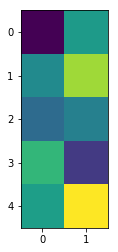

In [69]:
plt.imshow(factors[1])

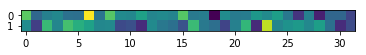

In [71]:
plt.imshow(factors[2].T)

(-0.002, 0.002)

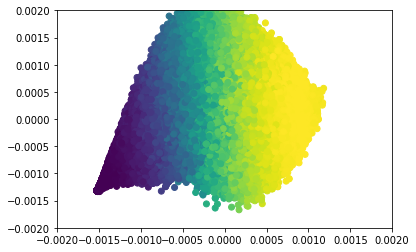

In [97]:
plt.scatter(
    factors[0].T[0], factors[0].T[1], 
    c=act_m
)
plt.xlim((-0.002,0.002))
plt.ylim((-0.002,0.002))

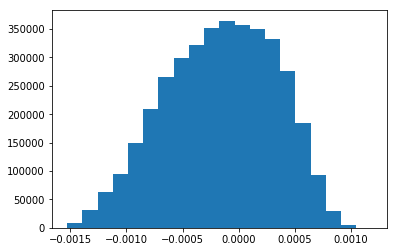

In [82]:
plt.hist(factors[0].T[0], bins=20)
plt.show()

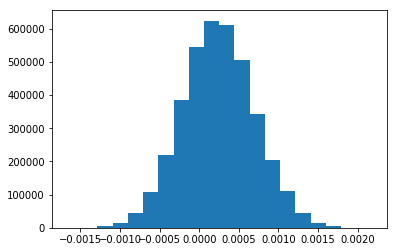

In [83]:
plt.hist(factors[0].T[1], bins=20)
plt.show()

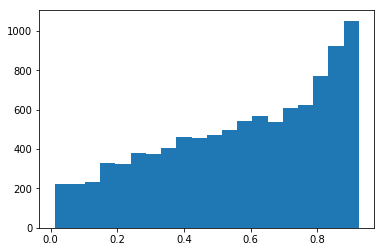

In [87]:
plt.hist(act_m[train_coords], bins=20)
plt.show()

In [77]:
np.min(factors[0].T[0])

-0.0015266808

In [78]:
np.max(factors[0].T[0])

0.0011817182

In [89]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [93]:
np.sum(factors[0], 1).shape

(3787448,)

In [126]:
np.random.seed(12314)
ln = linkage(factors[0][train_coords][:10000], "average")

In [127]:
train_seqs = seqs[train_coords]

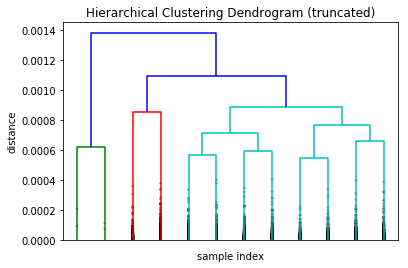

In [128]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    ln,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()



In [130]:
with open("ncvis_100000.pkl", "wb") as oh:
    pkl.dump((nv_cm, train_seqs), oh)

In [142]:
max_d = 0.00005

In [143]:
clusters = fcluster(ln, max_d, criterion='distance')

In [144]:
np.unique(clusters, return_counts = True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178

In [145]:
from weblogolib import *

In [153]:
def logo(n=1, folder="logos"):
    if not op.exists(folder):
        os.makedirs(folder)
    top20 = np.arange(train_seqs[0:10000].shape[0])[clusters == n]
    with open("test.fa", "w") as oh:
        for a in train_seqs[0:10000][top20]:
            oh.write(">\n"+a[:-2]+"\n")
    fin = open("test.fa")
    seqs = read_seq_data(fin)
    logodata = LogoData.from_seqs(seqs)
    logooptions = LogoOptions()
    logooptions.title = "Most Active Cluster Logo"
    logoformat = LogoFormat(logodata, logooptions)
    png = png_formatter(logodata, logoformat)
    with open(op.join(folder, str(n)+".png"), "wb") as oh:
        oh.write(png)
    act = act_m[train_coords][0:10000][top20]
    var = act_v[train_coords][0:10000][top20]
    return(act, var)

In [ ]:
train_coords

In [147]:
%%bash

rm -rf logos_10000_5/

In [154]:
mean_mean_act = []
mean_var_act = []
for a in tqdm(np.arange(np.unique(clusters).shape[0])):
    act, var = logo(a+1, "logos_10000_5")
    mean_mean_act.append(np.mean(act))
    mean_var_act.append(np.mean(var))

100%|██████████| 944/944 [05:18<00:00,  2.96it/s]


In [155]:
out_md = "out_10000_5.md"

In [174]:
fs = [op.join("logos_10000_5", a) for a in sorted(
    [a for a in os.walk("logos_10000_5")][0][2], 
    key=lambda x: int(x.split(".")[0])
)]

In [177]:
_, clusizes = np.unique(clusters, return_counts=True)

In [160]:
fs = list(sorted(fs, key=lambda x: mean_mean_act[fs.index(x)]))

In [178]:
fs_m = list(
    sorted(list(zip(fs, mean_mean_act, mean_var_act, clusizes)), key=lambda x: x[1])
)

In [179]:
with open(out_md, "w") as oh:
    for i,a in enumerate(fs_m):
        oh.write(op.split(a[0])[-1].split(".")[0]+"\n")
        oh.write("mean activity:"+str(a[1])+"\n")
        oh.write("mean variance:"+str(a[2])+"\n")
        oh.write("cluster size:"+str(a[3])+"\n")
        oh.write("![]("+a[0]+")\n")